# Multi-parameter calibration of the OpenCL RAMP model using ABC

### Parameter definitions
The OpenCL RAMP model creates a synthetic population and simulates the movements of individuals between various locations (home, work, school, shops). If an individual is infected then they impart an infection risk on to the locations that they visit. The severity of this infection risk is determined by whether the individual is presymptomatic, asymptomatic or symptomatic (the **individual's hazard rating**). The locations in the model thus come to have an infection risk, based upon how many infected individuals from each infection status have visited. When susceptible individuals without the disease visit these locations their risk of being infected is determined by the location's infection risk, alongside the transmission hazard associated with that kind of location (the **location's hazard rating**). An additional hazard rating, the current risk beta, is used to control the general transmissability of the disease. 

### Parameter calibration
The <ins>location</ins> and <ins>individual</ins> hazards, and the current risk beta rating must be calibrated to find the values which best reproduce real life observations. Here, the parameter values are calibrated once using historical data and Approximate Bayesian Computation (ABC). 

Prior distributions for each parameter are defined and then ABC approximates the likelihoods of different parameter values by running the model a large number of times. Each time parameter values are drawn randomly from the prior distributions, and the parameter values from the simulations with results closest to the observations are kept. A fitness function is used to assess the similarity of model results to observations. In this case, the Euclidean difference between the observed number of cases per week and the simulated number of cases per week is calculated. 

In this script, the predictive model is calibrated once. The model is ran using ABC for 133 days, with ten populations.  


### Parameter priors
ABC requires prior distributions to be specified for the parameters.

<ins>Location hazards</ins> 
 - `Home` (transmission hazard associated with being with an infected individual at home)
     - <i>Fixed at 1.0, so all other multipliers are relative to this. This is almost certaintly the most risky activity (i.e. transmission at home is very likely) so no other priors allow values above 1.0. </i>
 - `Retail` (transmission hazard associated with being with an infected individual in a shop)
     - <i> Uniform between 0 and 1 </i>
 - `PrimarySchool` (transmission hazard associated with being with an infected individual at primary school)
     - <i> Uniform between 0 and 1 </i> 
 - `SecondarySchool` (transmission hazard associated with being with an infected individual at secondary school)
     - <i> Uniform between 0 and 1 </i> 
 - `Work` (transmission hazard associated with being with an infected individual at work)
     - <i> Uniform between 0 and 1 </i> 
 
<ins> Individual hazards</ins> 
 - `asymptomatic` (transmission hazard associated with asymptomatic individuals)  
      - <i> This is tricky because we don't know the hazard associated with asymptomatic transmission. James Salter used a prior of: N(0.444, 0.155) which gives the middle 95% as [0.138, 0.75] ([0.138 estimated here](https://www.medrxiv.org/content/10.1101/2020.06.04.20121434v2), [0.58 estimated here](https://jammi.utpjournals.press/doi/abs/10.3138/jammi-2020-0030), [0.75 estimated here (Table 1)](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html). </i>
 - `presymptomatic` (transmission hazard associated with presymptomatic individuals)  
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ? </i>
 - `symptomatic` (transmission hazard associated with symptomatic individuals)   
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ?)</i>       


<ins> Other hazards</ins> 
- `current_risk_beta`  

<!-- To adapt an ABM to allow it to be optimised in response to data emerging in real time. This would mean performing dynamic calibration (i.e. re calibrating at every model time step) using ABC. -->

<!-- At the moment, however, such predictive ABMs are generally calibrated once, using historical data to adjust their more flexible parameters such that the model predicts present and past conditions well. The models are then allowed to roll forward in time, independent of the world, to make a prediction. As the systems modelled are usually complex, it is likely that over longer time periods such models diverge from realistic estimates. Even over shorter time periods there is little done to check model performance, let alone constrain it. -->

## Import modules

In [1]:
#### Import modules required
import multiprocessing as mp
import numpy as np
import os
import itertools
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sys
import datetime
from matplotlib import cm

# os.chdir("C:/Users/gy17m2a/OneDrive - University of Leeds/Project/RAMP-UA/experiments/calibration")

# PYABC (https://pyabc.readthedocs.io/en/latest/)
import pyabc
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior
# Quieten down the pyopencl info messages (just print errors)
import logging

logging.getLogger("pyopencl").setLevel(logging.ERROR)

# RAMP model
from microsim.initialisation_cache import InitialisationCache

# Bespoke RAMP classes for running the model
from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

# Set this to False to recalculate all results (good on HPC or whatever).
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


## Setup Model
Read parameters

In [2]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

c:\users\gy17m2a\onedrive - university of leeds\project\ramp-ua\microsim\opencl\ramp\params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "


#### Initialise the population
Define path to snapshot (i.e. an already-initialised model)

In [3]:
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

### Create observed cases data
Cases_devon_weekly is based on government data recording the number of new cases each week, per MSOA. It has been corrected to account for lags and other shortcomings in the testing process, and summed up to cover the whole of Devon. Full details are here: https://github.com/Urban-Analytics/RAMP-UA/blob/Mollys_DA/experiments/calibration/observation_data/CreatingObservations-Daily.ipynb

Cases_devon_daily is created through linear interpolation of the weekly data. This daily data is required for seeding the model. Because the interpolation is carried out for each MSOA seperately, when the data is joined back together for the whole of Devon it is not exactly equivalent to cases_devon_weekly. 

Currently, we are using the original cases_devon_weekly data in the distance function to evaluate the performance of the model. This makes sense because it is the most accurate weekly data that we have. However, it means when comparing the weekly model results to the observations, the model doesn't seem to be exactly the same as the observations, even during the seeding process. (Within the distance function all particles will be equally far from the observations during the seeding process, so shouldn't negatively affect things in this sense).

In [4]:
## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon.csv")
# Add column with cumulative sums rather than cases per week
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_weekly = cases_devon_weekly['CumulativeCases'].values

In [5]:
# Read in daily devon case data (interpolated from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon.csv")
# Add column with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_daily = cases_devon_daily['CumulativeCases'].values

In [6]:
# Convert this interpolated data used in seeding back to weekly
# List the index matching the end day of each week (e.g. 7, 14, 21 etc (minus 1 for indexing starting at 0)
n_days = len(cases_devon_daily)
week_end_days = list(range(6,n_days+1,7))

# Keep only the values from the end of each week
cases_devon_daily_summed_weekly = cases_devon_daily[week_end_days]

## Run model with default parameter values 

This shows what happens with the 'default' (manually calibrated) model, i.e. using the parameter values specified in the parameters file

#### Initialise model

In [7]:
## Define parameters
ITERATIONS = 133  # Number of iterations to run for
assert (ITERATIONS /7).is_integer() # check it is divisible by 7 
NUM_SEED_DAYS = 14  # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True

# x by 7 because daily data is used in running model?
assert ITERATIONS < len(cases_devon_weekly)*7,     f"Have more iterations ({ITERATIONS}) than observations ({len(cases_devon_weekly)*7})."

# Initialise the class so that its ready to run the model.
OpenCLRunner.init( iterations = ITERATIONS, repetitions = REPETITIONS, observations = cases_devon_weekly,
    use_healthier_pop = USE_HEALTHIER_POP, use_gpu = USE_GPU, store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE, opencl_dir = OPENCL_DIR,snapshot_filepath = SNAPSHOT_FILEPATH,
    num_seed_days = NUM_SEED_DAYS)

#### Run model

In [8]:
OpenCLRunner.update(repetitions=5)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness_manualcalibration, sim_mc, obs_mc, out_params_mc, summaries_mc) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True, quiet = False)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [03:52<00:00, 46.40s/it]


#### Plot results

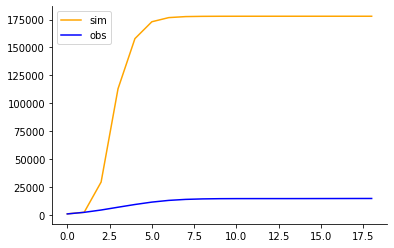

In [9]:
# Check the model returns the observations correctly i.e. that theyre the same length
np.array_equal(obs_mc, cases_devon_daily[:len(sim_mc)-1])

# Plot
fig, ax = plt.subplots(1,1)
x = range(len(sim_mc))
ax.plot(x, sim_mc, label="sim", color="orange")
ax.plot(x, obs_mc, label="obs", color="blue")
ax.legend()

## Calibrate model with Approximate Bayesian Computation
#### Define constants
These are not touched by ABC. Include parameters that should not be optimised.

In [10]:
const_params_dict = {"home": 1.0}

#### Define prior distributions for parameters to be optimised

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


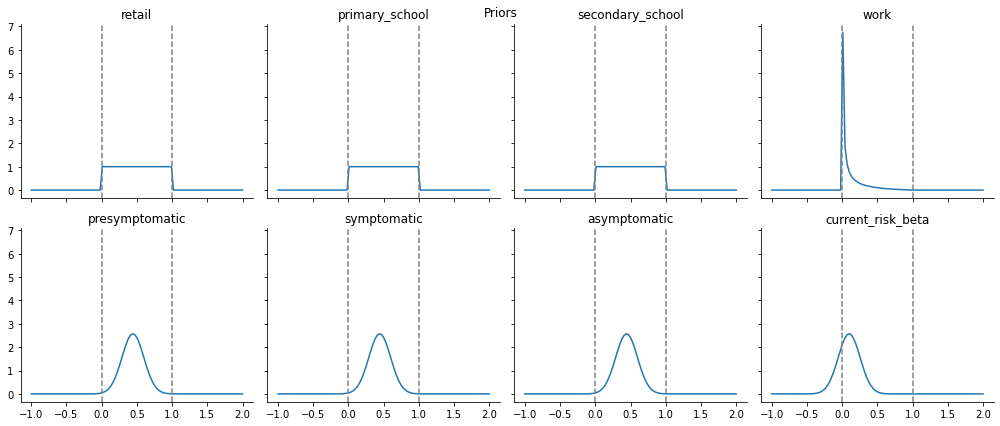

In [11]:
# Current risk beta
current_risk_beta_rv = pyabc.RV("norm", 0.1, 0.155)

# School and retail are all uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = ( pyabc.RV("uniform", 0, 1) for _ in range(3)  )
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers (see justification at the start of this notebook).
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = { "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv, 
    "current_risk_beta":current_risk_beta_rv}

# Plot prior distributions
fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, (var_name, variable) in enumerate(all_rv.items()):
    # var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    # ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")
fig.tight_layout()
fig.suptitle("Priors")
fig.show()

# Can decorate normal distributions later to make sure they are positive
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Create a distrubtion from these random variables
original_priors = pyabc.Distribution(**decorated_rvs)

### Initialise the ABC algorithm.

In [12]:
# Run length
run_length =133

# Initialise the population
DATA_DIR = os.path.join("..", "..", "devon_data")
cache_dir = os.path.join(DATA_DIR, "caches")
cache = InitialisationCache(cache_dir=cache_dir)
if cache.is_empty():
    raise Exception(f"The cache in {cache_dir} has not been initialised. Probably need to run the code a",
                    "few cells up that initialises the population")

individuals_df, activity_locations = cache.read_from_cache()
print(f"Activity locations: {activity_locations}")


# Dictionary with parameters for running model
admin_params = {"quiet": True, "use_gpu": True, "store_detailed_counts": True, "start_day": 0,  "run_length": run_length,
                "current_particle_pop_df": None,  "parameters_file": PARAMETERS_FILE, "snapshot_file": SNAPSHOT_FILEPATH, 
                "opencl_dir": OPENCL_DIR, "individuals_df": individuals_df, "observations_weekly_array": cases_devon_weekly,
                'num_seed_days' :14}

Activity locations: {'Home': <Home ActivityLocation>, 'Retail': <Retail ActivityLocation>, 'PrimarySchool': <PrimarySchool ActivityLocation>, 'SecondarySchool': <SecondarySchool ActivityLocation>, 'Work': <Work ActivityLocation>}


### Set-up ABC

In [14]:
# Create template for model
template = OpenCLWrapper(const_params_dict, **admin_params)
# Not sure why this is needed. Wthout it we get an error when passing the template object to ABCSMC below
template.__name__ = OpenCLWrapper.__name__

# Set up model
abc = pyabc.ABCSMC(models=template, parameter_priors=original_priors, distance_function=OpenCLWrapper.dummy_distance, 
    sampler=pyabc.sampler.SingleCoreSampler(), transitions=GreaterThanZeroParameterTransition())

# Prepare to run the model
db_path = ("sqlite:///" + "test3.db")  # Path to database

# abc.new() needs the database location and any observations that we will use (these are passed to the distance_function
# provided to pyabc.ABCSMC above). Currently the observations are provided to the model when it is initialised and 
# these are then used at the end of the model run() function. So they don't need to be provided here.
abc_history = abc.new(db=db_path,observed_sum_stat=None)  # {'observation': observations_array, "individuals": individuals_df}
run_id = abc_history.id

ABC.History INFO: Start <ABCSMC id=1, start_time=2022-03-22 16:12:07>


### Run ABC

In [17]:
# Run model
abc_history = abc.run(max_nr_populations=10)

### Resume ABC run

In [169]:
# # Set up model
# abc_continued = pyabc.ABCSMC(models=template, parameter_priors=original_priors, distance_function=OpenCLWrapper.dummy_distance,  
#     sampler=pyabc.sampler.SingleCoreSampler(),transitions=GreaterThanZeroParameterTransition())
# # To resume a run, use the load method to load the necessary data. We pass to this method the id of the run we want to continue
# abc_continued.load(db_path, run_id)
# # run it
# abc_continued.run(max_nr_populations=3)

#### Check number of populations

In [22]:
abc_history.n_populations

11

### Save ABC model results

In [184]:
fname = "InitialModelCalibration-10pops-133days.pkl"
with open( fname, "wb" ) as f:
        pickle.dump(abc_history, f)

### Analyse the posterior parameter distribution
Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

Note about the distrubtion returned by get_distribution: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [23]:
_df, _w = abc_history.get_distribution(m=0, t=abc_history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,current_risk_beta,presymptomatic,primary_school,retail,secondary_school,symptomatic,work,weight
0,1059,0.411005,0.019494,0.371609,0.609788,0.640238,0.536117,0.737517,0.008547,4.114961e-01
1,1010,0.425669,0.020267,0.302121,0.334402,0.635305,0.428977,0.183721,0.001784,1.808164e-01
2,1057,0.427592,0.019932,0.320992,0.326276,0.479450,0.436124,0.305571,0.006641,9.026367e-02
3,1047,0.387450,0.024562,0.456401,0.402043,0.440543,0.112659,0.393378,0.009905,6.251195e-02
4,1097,0.355256,0.024404,0.452691,0.386018,0.556082,0.118495,0.148083,0.002968,5.800614e-02
...,...,...,...,...,...,...,...,...,...,...
95,1030,0.713305,0.016143,0.265550,0.136253,0.034475,0.143523,0.350480,0.041867,1.089408e-05
96,1026,0.692876,0.016850,0.265832,0.106939,0.125998,0.117686,0.377868,0.042971,9.482172e-06
97,1093,0.770151,0.012432,0.223375,0.083138,0.113885,0.121011,0.414821,0.046128,4.628446e-06
98,1091,0.831652,0.011525,0.210708,0.033064,0.029907,0.069162,0.421935,0.055529,2.517291e-06


#### Plot the marginal posteriors  
The estimates of the optimal values for each parameter individually

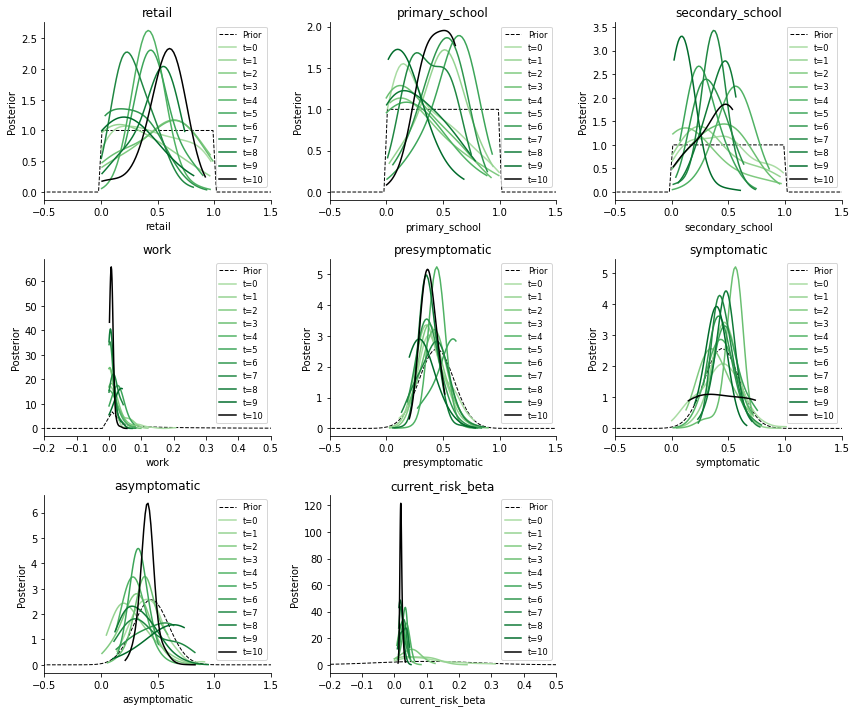

In [25]:
fig, axes = plt.subplots(3,3, figsize=(12,10))
# define colour map
evenly_spaced_interval = np.linspace(0.35, 1, 12)
colors = [cm.Greens(x) for x in evenly_spaced_interval]

for i, param in enumerate(original_priors.keys()):
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    # Add distributions
    for t in range(abc_history.max_t + 1):
        color = colors[t]
        df, w = abc_history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"t={t}", 
            #alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= 'black' if t==abc_history.max_t else color) # Make the last one black
        if param!="work":
            ax.set_xlim(-0.5,1.5)
        if param =='work':
             ax.set_xlim(-0.2,0.5)          
        if param =='current_risk_beta':
             ax.set_xlim(-0.2,0.5)                   
        ax.legend(fontsize="small")
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
axes[2,2].set_axis_off()        
fig.tight_layout()

### Analyse the model predictions within each ABC calibration population

#### Store predictions and distances for each particle in each population 

In [26]:
# Create dictionary to store results for each population
abc_sum_stats = {}

# Loop through each population
for t in range(0,abc_history.max_t+1):
    # Create lists to store values for each particle
    data_daily_l = []
    distances_l = []

    # Get the summary stats for this population
    # ([1] means keep just the dataframe and not the array of weights)
    weighted_sum_stats = abc_history.get_weighted_sum_stats_for_model(t=t)[1]

    # Loop through each particle and save their distance and predictions into the lists
    for particle_no in range(0,100):
        # Get data for just this particle
        particle_x_dict = weighted_sum_stats[particle_no]
        # Get daily predictions
        data_daily = particle_x_dict["model_daily_cumulative_infections"]     
        # Add daily msoa predictions for this particle to list
        data_daily_l.append(data_daily)
        
        # Add distances to list
        distances_l.append(particle_x_dict['distance'])
    
    # Add lists to dictionaries    
    abc_sum_stats["t{}_distances".format(t)] = distances_l
    abc_sum_stats["t{}_dailydata".format(t)] = data_daily_l

#### Create plot of daily cumulative infections with one subplot per population and one line per particle

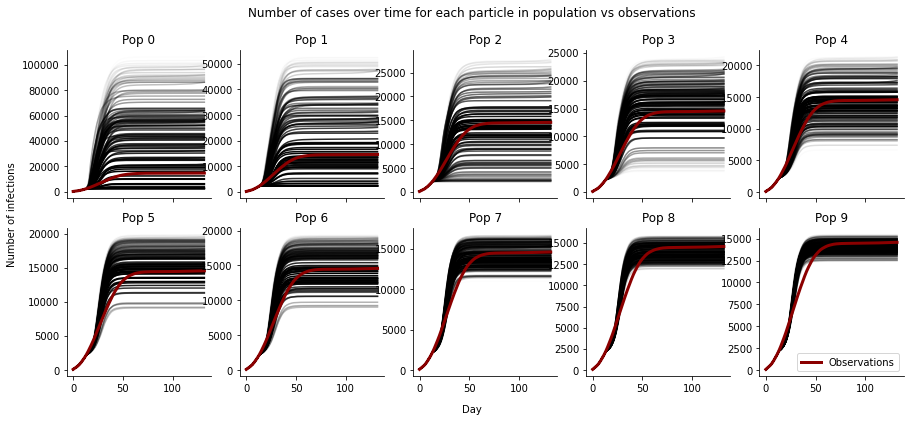

In [153]:
# Create figure
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), sharex=True)

# Loop through each population (t) and each axes on the subplot 
for t,ax in zip(range(0,abc_history.max_t+1),axs.ravel()):
    
    # Get the data for this population
    data_daily_l = abc_sum_stats["t{}_dailydata".format(t)]
    distance_l = abc_sum_stats["t{}_distances".format(t)]
    
    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
    
    # Create x axis object, with position for each day 
    day_nos = range(0,len(data_daily_l[t])) 
    
    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(data_daily_l)):
        ax.plot(day_nos, data_daily_l[i],color="black", alpha=1-distance_norm[i])  # (1-x because high distance is bad)

    # Add observations
    ax.plot(day_nos, cases_devon_daily[0:len(data_daily_l[0])], label="Observations", linewidth = 3, color="darkred")

    # Apply labels
    ax.set_title("Pop {}".format(t))

    # Set full plot title
    fig.suptitle("Number of cases over time for each particle in population vs observations")

fig.text(0.5, 0.04, 'Day', ha='center')
fig.text(0.07, 0.5, 'Number of infections', va='center', rotation='vertical')
ax.legend(fontsize="medium")

#### Create plot of daily cumulative infections with one subplot per population and the line showing the predictions of the best performing particle

Text(0.5, 0.98, 'Number of cases over time for best performing particle vs observations')

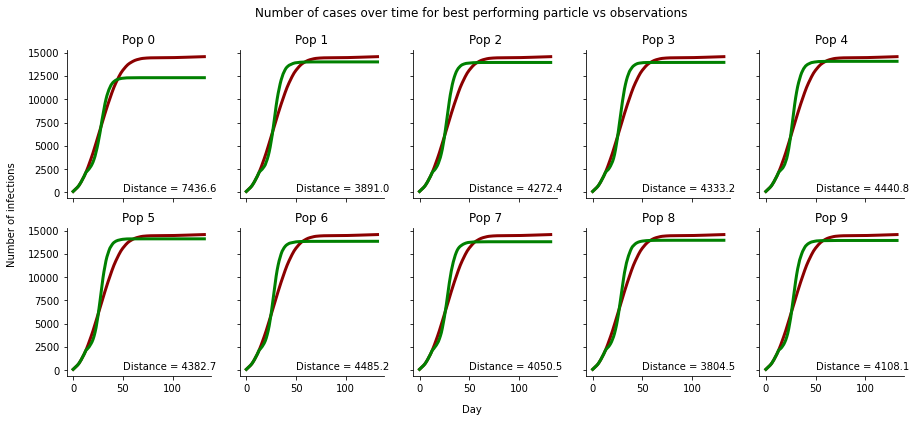

In [150]:
# Create figure
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), sharex=True, sharey = True)

# Loop through each population (t) and each axes on the subplot 
for t, ax in zip(range(0,abc_history.max_t+1),axs.ravel()):
        
    data_daily_l = abc_sum_stats["t{}_dailydata".format(t)]
    distance_l = abc_sum_stats["t{}_distances".format(t)]

    # Find the best particle
    best_particle_idx = distance_l.index(min(distance_l))
        
    # Add observations
    ax.plot(x, cases_devon_daily[0:len(data_daily_l[0])], label="Observations", linewidth = 3, color="darkred")

    # Add the best particle
    ax.plot(x, data_daily_l[best_particle_idx], color="green", linewidth = 3,label = 'Best particle')
    
    # Add text with distance value for best performing particle
    ax.text(50, 60, 'Distance = {}'.format(round(distance_l[best_particle_idx],1)), fontsize = 10)
        
    # Apply labels
    ax.set_title("Pop {}".format(t))

fig.text(0.5, 0.04, 'Day', ha='center')
fig.text(0.07, 0.5, 'Number of infections', va='center', rotation='vertical')
fig.suptitle("Number of cases over time for best performing particle vs observations")


## Find the optimal value for Current Risk Beta (and other parameters)

Plot the relationship between currrent risk beta and distance for the final population

Text(0, 0.5, 'Distance')

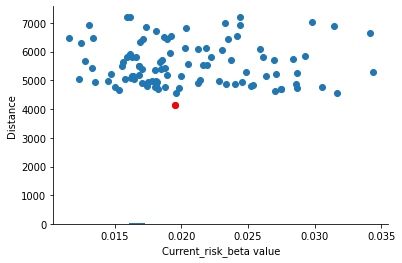

In [141]:
# Get the list of distances for the final population
distance_l = abc_sum_stats["t{}_distances".format(10)]

# Find the best particle (i.e. the minimum distance)
best_particle_idx = distance_l.index(min(distance_l))

# Get the parameter values associated with each particle in final population
params_df, _w = abc_history.get_distribution(m=0, t=abc_history.max_t)

# Plot once with all particles
plt.scatter(params_df['current_risk_beta'], distance_l)
# Plot with just best particle in a different colour
plt.scatter(params_df['current_risk_beta'].iloc[best_particle_idx], distance_l[best_particle_idx], c = 'red')
plt.xlabel('Current_risk_beta value')
plt.ylabel('Distance')

Plot the relationship between currrent risk beta and distance for each population

Text(0.07, 0.5, 'Number of infections')

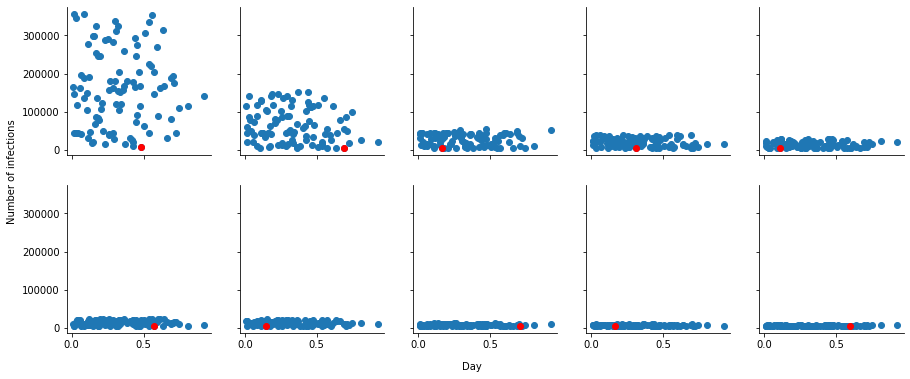

In [146]:
# Create figure
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), sharex=True, sharey = True)

# Loop through each population (t) and each axes on the subplot 
for t, ax in zip(range(0,abc_history.max_t+1),axs.ravel()):
        
    # Get the list of distances for the final population
    distance_l = abc_sum_stats["t{}_distances".format(t)]

    # Find the best particle (i.e. the minimum distance)
    best_particle_idx = distance_l.index(min(distance_l))

    # Get the parameter values associated with each particle in final population
    params_df, _w = abc_history.get_distribution(m=0, t=abc_history.max_t)

#     plt.hist(params_df['current_risk_beta'], bins = 20)
    ax.scatter(params_df['current_risk_beta'], distance_l)
    ax.scatter(params_df['current_risk_beta'].iloc[best_particle_idx], distance_l[best_particle_idx], c = 'red')
#     ax.xlabel('Current_risk_beta value')
#     ax.ylabel('Distance')

fig.text(0.5, 0.04, 'Day', ha='center')
fig.text(0.07, 0.5, 'Number of infections', va='center', rotation='vertical')

For the final population find the best performing particle (i.e. the one with the minimum distance value) and get the parameter values associated with this particle

In [155]:
# Get the list of distances for the final population
distance_l = abc_sum_stats["t{}_distances".format(abc_history.max_t )]

# Find the best particle (i.e. the minimum distance)
best_particle_idx = distance_l.index(min(distance_l))

# Get the parameter values associated with each particle in final population
params_df, _w = abc_history.get_distribution(m=0, t=abc_history.max_t)

# Find the parameters associated with the best particle
best_params = params_df.iloc[best_particle_idx]
best_params

name
asymptomatic         0.411005
current_risk_beta    0.019494
presymptomatic       0.371609
primary_school       0.609788
retail               0.640238
secondary_school     0.536117
symptomatic          0.737517
work                 0.008547
Name: 1059, dtype: float64

See how the 'optimal' parameter values relate to the marginal posterior distributions

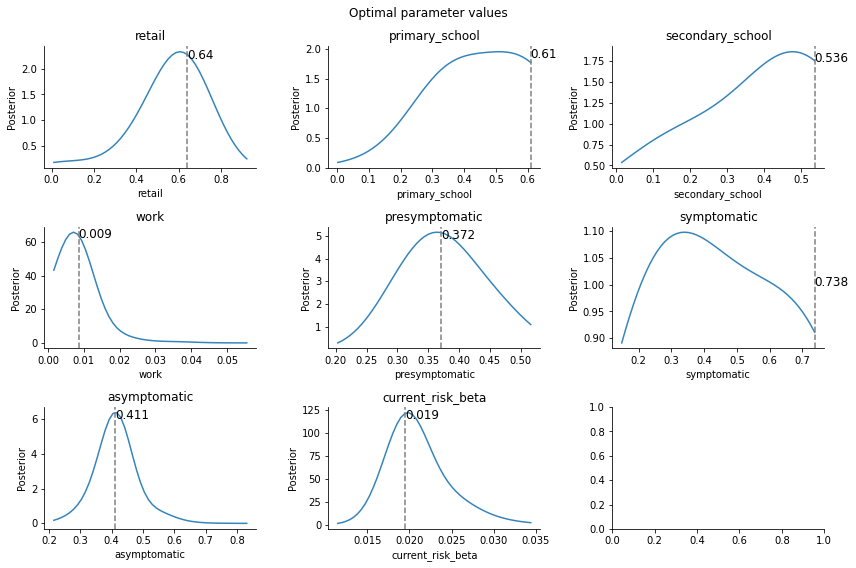

In [161]:
fig, axes = plt.subplots(3,3, figsize=(12,8))

for i, param in enumerate(original_priors.keys()):
    ax = axes.flat[i]
    df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
            label=f"{param} PDF t={t}",
            alpha=1.0 if t==0 else float(t)/abc_history.max_t, # Make earlier populations transparent
            color= "black" if t==abc_history.max_t else None # Make the last one black)
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

Run the model with the 'optimal' parameter values

In [162]:
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(distance_bp, sim_bp, obs_bp, out_params_bp, summaries_bp) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True, quiet = False)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [03:11<00:00, 38.28s/it]


Text(0, 0.5, 'Cases')

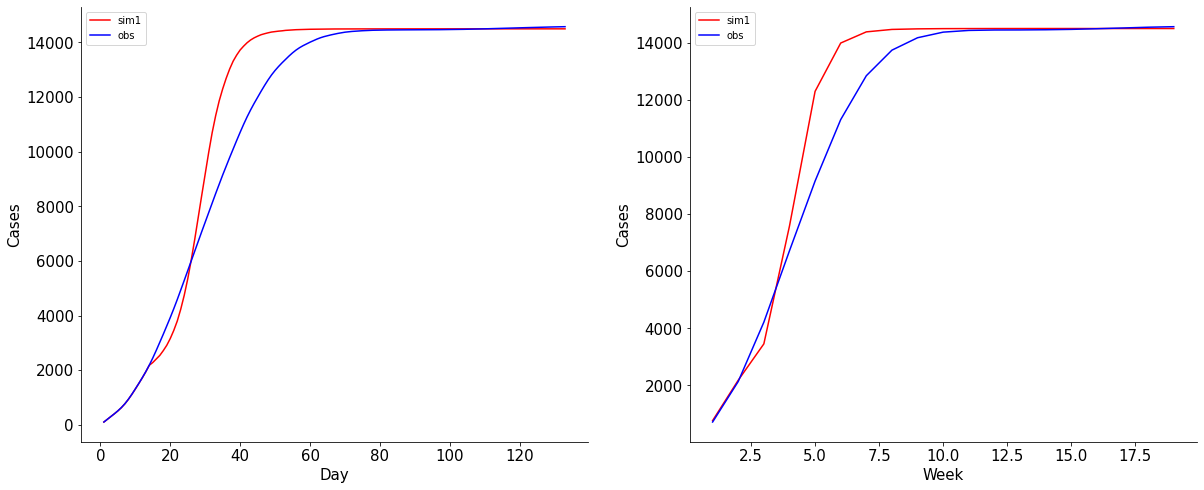

In [175]:
# Create figure
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

##### daily data
x = range(1, len(OpenCLRunner.get_cumulative_daily_infections(summaries_bp))+1)
ax1.plot(x, OpenCLRunner.get_cumulative_daily_infections(summaries_bp), label="sim1", color="red")
ax1.plot(x, cases_devon_daily[0:len(OpenCLRunner.get_cumulative_daily_infections(summaries_bp))], label="obs", color="blue")
ax1.legend()
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Day", size=15)
ax1.set_ylabel("Cases",size=15)

###### weekly data
x = range(1, len(sim_bp)+1)
ax2.plot(x, sim_bp, label="sim1", color="red")
ax2.plot(x, obs_bp, label="obs", color="blue")
ax2.legend()
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Week", size=15)
ax2.set_ylabel("Cases",size=15)   